# Panel Data and Fixed Effects

## Controlling What you Cannot See

Methods like propensity score, linear regression and matching are very good at controlling for confounding in non-random data, but they rely on a key assumption: conditional unconfoundedness

$
(Y_0, Y_1) \perp T | X
$

To put it in words, they require that all the confounders are known and measured, so that we can condition on them and make the treatment as good as random. One major issue with this is that sometimes we simply can't measure a confounder. For instance, take a classical labor economics problem of figuring out the impact of marriage on men's earnings. It's a well known fact in Economics that married men earn more than single men. What is not as clear is if this relationship is causal or not. It could be that more educated people are both more likely to marry and more likely to have a high earnings job, which would mean that education is a confounder of the effect of marriage on earnings. For this confounder, we could measure the education of the person in the study and run a regression controlling for that. But another confounder could be beauty. It could be that more handsome men are both more likely to get married and more likely to have a high paying job. Unfortunately, beauty is one of those characteristics like intelligence. It's something we can't measure very well.  

This puts us in a difficult situation, because if we have unmeasured confounders, we have bias. One way to deal with this is with instrumental variables, like we've seen before. But coming up with good instruments it's no easy task and requires a lot of creativity. Here, let's look at an alternative that takes advantage of time or the temporal structure of data. 

The idea is to use **panel data**. Panel data is when we have **observations on the same individual for multiple periods of time**. Panel data formats are very common in the industry, where they keep records of customer behavior for the same customer and for multiple time periods. The reason we can leverage panel data is because we can compare the same unit before and after the treatment and see how they behave with it. Before we dive in the math, let's see how this makes intuitive sense.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

from linearmodels.panel import PanelOLS


%matplotlib inline
pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

First, let's take a look at the causal graph that we have once we include multiple observations of the same unit across time. Suppose we have a situation where marriage at the first time causes income at the same time and subsequent marital status. This is also true for times 2 and 3. Also, suppose that beauty is the same across all time periods (a bold statement, but reasonable if time is just a few years) and it causes both marriage and income.

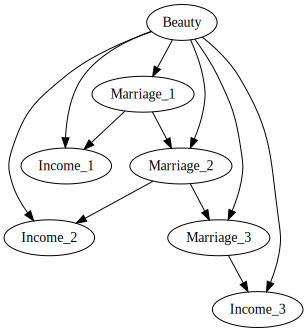

In [2]:
g = gr.Digraph()
g.edge("Marriage_1", "Income_1")
g.edge("Marriage_1", "Marriage_2")
g.edge("Marriage_2", "Income_2")
g.edge("Marriage_2", "Marriage_3")
g.edge("Marriage_3", "Income_3")

g.edge("Beauty", "Marriage_1")
g.edge("Beauty", "Marriage_2")
g.edge("Beauty", "Marriage_3")

g.edge("Beauty", "Income_1")
g.edge("Beauty", "Income_2")
g.edge("Beauty", "Income_3")

g

Remember that we cannot control beauty, since we can't measure it. But we can still use the panel structure so it is not a problem anymore. The idea is that we can see beauty - and any other attribute that is constant across time - as the defining aspects of a person. And although we can't control them directly, we can control for the individual itself.

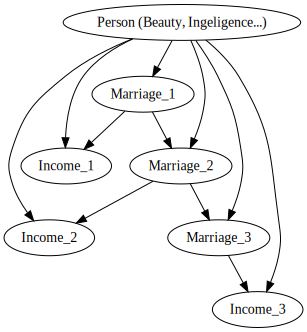

In [3]:
g = gr.Digraph()
g.edge("Marriage_1", "Income_1")
g.edge("Marriage_1", "Marriage_2")
g.edge("Marriage_2", "Income_2")
g.edge("Marriage_2", "Marriage_3")
g.edge("Marriage_3", "Income_3")

g.edge("Person (Beauty, Ingeligence...)", "Marriage_1")
g.edge("Person (Beauty, Ingeligence...)", "Marriage_2")
g.edge("Person (Beauty, Ingeligence...)", "Marriage_3")

g.edge("Person (Beauty, Ingeligence...)", "Income_1")
g.edge("Person (Beauty, Ingeligence...)", "Income_2")
g.edge("Person (Beauty, Ingeligence...)", "Income_3")

g

Think about it. We can't measure attributes like beauty and intelligence, but we know that the person who has them is the same individual across time. So, we can create a dummy variable indicating that person and add that to a linear model. This is what we mean when we say we can control for the person itself: we are adding a variable (dummy in this case) that denotes that particular person. When estimating the effect of marriage on income with this person dummy in our model, regression finds the effect of marriage **while keeping the person variable fixed**. Adding this entity dummy is what we call a fixed effect model.


## Fixed Effects

To make matters more formal, let's first take a look at the data that we have. Following our example, we will try to estimate the effect of marriage on income. Our data contains those 2 variables, `married` and `lwage`, on multiple individuals (`nr`) for multiple years. Note that wage is in log form. In addition to this, we have other controls, like number of hours worked that year, years of education and so on.

In [4]:
from linearmodels.datasets import wage_panel
data = wage_panel.load()
data.head()

,nr,year,black,...,lwage,expersq,occupation
0,13,1980,0,...,1.197540,1,9
1,13,1981,0,...,1.853060,4,9
2,13,1982,0,...,1.344462,9,9
3,13,1983,0,...,1.433213,16,9
4,13,1984,0,...,1.568125,25,5


Generally, the fixed effect model is defined as

$
y_{it} = \beta X_{it} + \gamma U_i + e_{it}
$

where \\(y_{it}\\) is the outcome of individual \\(i\\) at time \\(t\\), \\(X_{it}\\) is the vector of variables for individual \\(i\\) at time \\(t\\). \\(U_i\\) is a set of unobservables for individual \\(i\\). Notice that those unobservables are unchanging through time, hence the lack of the time subscript. Finally,  \\(e_{it}\\) is the error term. For the education example, \\(y_{it}\\) is log wages,  \\(X_{it}\\) are the observable variables that change in time, like marriage and experience and \\(U_i\\) are the variables that are not observed but constant for each individual, like beauty and intelligence. 


Now, remember how I've said that using panel data with a fixed effect model is as simple as adding a dummy for the entities. It's true, but in practice, we don't actually do it. Imagine a dataset where we have 1 million customers. If we add one dummy for each of them, we would end up with 1 million columns, which is probably not a good idea. Instead, we use the trick of partitioning the linear regression into 2 separate models. We've seen this before, but now is a good time to recap it. Suppose you have a linear regression model with a set of features \\(X_1\\) and another set of features \\(X_2\\).

$
\hat{Y} = \hat{\beta_1} X_1 + \hat{\beta_2} X_2
$

where \\(X_1\\) and \\(X_1\\) are feature matrices (one row per feature and one column per observation) and \\(\hat{\beta_1}\\) and \\(\hat{\beta_2}\\) are row vectors. You can get the exact same \\(\hat{\beta_1}\\) parameter by doing

1. regress the the outcome \\(y\\) on the second set of features \\(\hat{y^*} = \hat{\gamma_1} X_2\\)
2. regress the first set of features on the second \\(\hat{X_1} = \hat{\gamma_2} X_2\\)
3. obtain the residuals \\(\tilde{X}_1 = X_1 - \hat{X_1}\\) and \\(\tilde{y}_1 = y_1 - \hat{y^*}\\)
4. regress the residuals of the outcome on the residuals of the features \\(\hat{y} = \hat{\beta_1} \tilde{X}_1\\)

The parameter from this last regression will be exactly the same as running the regression with all the features. But how exactly does this help us? Well, we can break the estimation of the model with the entity dummies into 2. First, we use the dummies to predict the outcome and the feature. These are steps 1 and 2 above. 

Now, remember how running a regression on a dummy variable is as simple as estimating the mean for that dummy? If you don't, let's use our data to show how this is true. Let's run a model where we predict wages as a function of the year dummy. 

In [5]:
mod = smf.ols("lwage ~ C(year)", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.3935,0.022,63.462,0.000,1.350,1.437
C(year)[T.1981],0.1194,0.031,3.845,0.000,0.059,0.180
C(year)[T.1982],0.1782,0.031,5.738,0.000,0.117,0.239
C(year)[T.1983],0.2258,0.031,7.271,0.000,0.165,0.287
C(year)[T.1984],0.2968,0.031,9.558,0.000,0.236,0.358
C(year)[T.1985],0.3459,0.031,11.140,0.000,0.285,0.407
C(year)[T.1986],0.4062,0.031,13.082,0.000,0.345,0.467
C(year)[T.1987],0.4730,0.031,15.232,0.000,0.412,0.534


Notice how this model is predicting the average income in 1980 to be 1.3935, in 1981 to be 1.5129 (1.3935+0.1194) and so on. Now, if we compute the average by year, we get the exact same result. (Remember that the base year, 1980, is the intercept. So you have to add the intercept to the parameters of the other years to get the mean `lwage` for the year).

In [6]:
data.groupby("year")["lwage"].mean()

year
1980    1.393477
1981    1.512867
1982    1.571667
1983    1.619263
1984    1.690295
1985    1.739410
1986    1.799719
1987    1.866479
Name: lwage, dtype: float64

This means that if we get the average for every person in our panel, we are essentially regressing the individual dummy on the other variables. This motivates the following estimation procedure:

1. Create time-demeaned variables by subtracting the mean for the individual:   
$\ddot{Y}_{it} = Y_{it} -  \bar{Y}_i$  
$\ddot{X}_{it} = X_{it} -  \bar{X}_i$

2. Regress $\ddot{Y}_{it}$ on $\ddot{X}_{it}$


Notice that when we do so, the unobserved \\(U_i\\) vanishes. Since \\(U_i\\) is constant across time, we have that \\(\bar{U_i}=U_i\\). If we have the following system of two equations

$$
\begin{align}
Y_{it} & = \beta X_{it} + \gamma U_i + e_{it} \\
\bar{Y}_{i} & = \beta \bar{X}_{it} + \gamma \bar{U}_i + \bar{e}_{it} \\
\end{align}
$$

And we subtract one from the other, we get

$$
\begin{align}
(Y_{it} - \bar{Y}_{i}) & = (\beta X_{it} - \beta \bar{X}_{it}) + (\gamma U_i - \gamma U_i) + (e_{it}-\bar{e}_{it}) \\
(Y_{it} - \bar{Y}_{i}) & = \beta(X_{it} - \bar{X}_{it}) + (e_{it}-\bar{e}_{it}) \\
\ddot{Y}_{it} & = \beta \ddot{X}_{it} + \ddot{e}_{it} \\
\end{align}
$$

which wipes out all unobserved that are constant across time. To be honest, not only do the unobserved variables vanish. This happens to all the variables that are constant in time. For this reason, you can't include any variables that are constant across time, as they would be a linear combination of the dummy variables and the model wouldn't run. 

![img](./data/img/fixed-effects/demeaned.png)

To check which variables are those, we can group our data by individual and get the sum of the standard deviations. If it is zero, it means the variable isn't changing across time for any of the individuals. 

In [7]:
data.groupby("nr").std().sum()

year            1334.971910
black              0.000000
exper           1334.971910
hisp               0.000000
hours         203098.215649
married          140.372801
educ               0.000000
union            106.512445
lwage            173.929670
expersq        17608.242825
occupation       739.222281
dtype: float64

For our data, we need to remove entinicity dummies, `black` and `hisp`, since they are constant for the individual. Also, we need to remove education. We will also not use occupation, since this is probably mediating the effect of marriage on wage (it could be that single men are able to take more time demanding positions). Having selected the features we will use, it's time to estimate this model.

To run our fixed effect model, first, let's get our mean data. We can achieve this by grouping everything by individuals and taking the mean.

In [8]:
Y = "lwage"
T = "married"
X = [T, "expersq", "union", "hours"]

mean_data = data.groupby("nr")[X+[Y]].mean()
mean_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.000,25.5,0.125,2807.625,1.255652
17,0.000,61.5,0.000,2504.125,1.637786
18,1.000,61.5,0.000,2350.500,2.034387
45,0.125,35.5,0.250,2225.875,1.773664
110,0.500,77.5,0.125,2108.000,2.055129


To demean the data, we need to set the index of the original data to be the individual identifier, `nr`. Then, we can simply subtract one data frame from the mean data frame.

In [9]:
deamed_data = (data
               .set_index("nr") # set the index as the person indicator
               [X+[Y]]
               - mean_data) # subtract the mean data

deamed_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.0,-24.5,-0.125,-135.625,-0.058112
13,0.0,-21.5,0.875,-487.625,0.597408
13,0.0,-16.5,-0.125,132.375,0.088810
13,0.0,-9.5,-0.125,152.375,0.177561
13,0.0,-0.5,-0.125,263.375,0.312473


Finally, we can run our fixed effect model on the time-demeaned data.

In [10]:
mod = smf.ols(f"{Y} ~ {'+'.join(X)}", data=deamed_data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-8.327e-17,0.005,-1.64e-14,1.000,-0.010,0.010
married,0.1147,0.017,6.756,0.000,0.081,0.148
expersq,0.0040,0.000,21.958,0.000,0.004,0.004
union,0.0784,0.018,4.261,0.000,0.042,0.115
hours,-8.46e-05,1.25e-05,-6.744,0.000,-0.000,-6e-05


If we believe that fixed effect eliminates the all omitted variable bias, this model is telling us that marriage increases a man's wage by 11%. This result is very significant. One detail here is that for fixed effect models, the standard errors need to be clustered. So, instead of doing all our estimation by hand (which is only nice for pedagogical reasons), we can use the library `linearmodels` and set the argument `cluster_entity` to True.

In [11]:
from linearmodels.panel import PanelOLS
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,0.0040,0.0002,16.552,0.0000,0.0035,0.0044
union,0.0784,0.0236,3.3225,0.0009,0.0322,0.1247
married,0.1147,0.0220,5.2213,0.0000,0.0716,0.1577
hours,-8.46e-05,2.22e-05,-3.8105,0.0001,-0.0001,-4.107e-05


Notice how the parameter estimates are identical to the ones we've got with time-demeaned data. The only difference is that the standard errors are a bit larger. Now, compare this to the simple OLS model that doesn't take the time structure of the data into account. For this model, we add back the variables that are constant in time.

In [12]:
mod = smf.ols("lwage ~ expersq+union+married+hours+black+hisp+educ", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2654,0.065,4.103,0.000,0.139,0.392
expersq,0.0032,0.000,15.750,0.000,0.003,0.004
union,0.1829,0.017,10.598,0.000,0.149,0.217
married,0.1410,0.016,8.931,0.000,0.110,0.172
hours,-5.32e-05,1.34e-05,-3.978,0.000,-7.94e-05,-2.7e-05
black,-0.1347,0.024,-5.679,0.000,-0.181,-0.088
hisp,0.0132,0.021,0.632,0.528,-0.028,0.054
educ,0.1057,0.005,22.550,0.000,0.097,0.115


This model is saying that marriage increases the man's wage by 14%. A somewhat larger effect than the one we found with the fixed effect model. This suggests some omitted variable bias due to fixed individual factors, like intelligence and beauty, not being added to the model.

## Visualizing Fixed Effects

To expand our intuition about how fixed effect models work, let's diverge a little to another example. Suppose you work for a big tech company and you want to estimate the impact of a billboard marketing campaign on in-app purchase. When you look at data from the past, you see that the marketing department tends to spend more to place billboards on cities where the purchase level is lower. This makes sense right? They wouldn't need to do lots of advertisement if sales were skyrocketing. If you run a regression model on this data, it looks like higher cost in marketing leads to less in-app purchase, but only because marketing investments is biased towards low spending regions. 

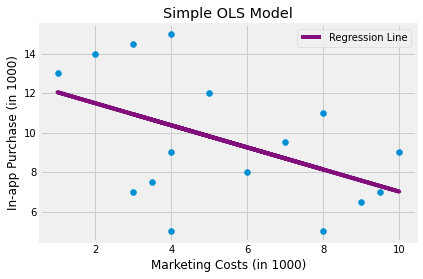

In [13]:
toy_panel = pd.DataFrame({
    "mkt_costs":[5,4,3.5,3, 10,9.5,9,8, 4,3,2,1, 8,7,6,4],
    "purchase":[12,9,7.5,7, 9,7,6.5,5, 15,14.5,14,13, 11,9.5,8,5],
    "city":["C0","C0","C0","C0", "C2","C2","C2","C2", "C1","C1","C1","C1", "C3","C3","C3","C3"]
})

m = smf.ols("purchase ~ mkt_costs", data=toy_panel).fit()

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase)
plt.plot(toy_panel.mkt_costs, m.fittedvalues, c="C5", label="Regression Line")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)")
plt.title("Simple OLS Model")
plt.legend();

Knowing a lot about causal inference, you decide to run a fixed effect model, adding the cities indicator as a dummy variable to your model. The fixed effect model controls for city specific characteristics that are constant in time, so if a city is less open to your product, it will capture that. When you run that model, you can finally see that more marketing costs leads to higher in-app purchase.

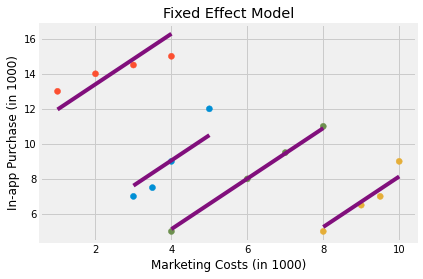

In [14]:
fe = smf.ols("purchase ~ mkt_costs + C(city)", data=toy_panel).fit()

fe_toy = toy_panel.assign(y_hat = fe.fittedvalues)

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase, c=toy_panel.city)
for city in fe_toy["city"].unique():
    plot_df = fe_toy.query(f"city=='{city}'")
    plt.plot(plot_df.mkt_costs, plot_df.y_hat, c="C5")

plt.title("Fixed Effect Model")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)");

Take a minute to appreciate what the image above is telling you about what fixed effect is doing. Notice that fixed effect is fitting **one regression line per city**. Also notice that the lines are parallel. The slope of the line is the effect of marketing costs on in-app purchase. So the **fixed effect is assuming that the causal effect is constants across all entities**, which are cities in this case. This can be a weakness or an advantage, depending on how you see it. It is a weakness if you are interested in finding the causal effect per city. Since the FE model assumes this effect is constant across entities, you won't find any difference in the causal effect. However, if you want to find the overall impact of marketing on in-app purchase, the panel structure of the data is a very useful leverage that fixed effects can explore. 

## Time Effects

Just like we did a fixed effect for the individual level, we could design a fixed effect for the time level. If adding a dummy for each individual controls for fixed individual characteristics, adding a time dummy would control for variables that are fixed across time. One example of such a variable is inflation. Prices and salary tend to go up with time. If the wage and marriage proportion also changes with time, we would have time as a confounder. To give a more concrete example, suppose that marriage is increasing with time. Since inflation also makes salary increase with time, some of the positive association we see between marriage and wage would be simply because both are increasing with time. To correct for that, we can add a dummy variable for each time period. In `linear models`, this is as simple as adding `TimeEffects` to our formula and setting the `cluster_time` to true.

In [15]:
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects+TimeEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,-0.0062,0.0008,-8.1479,0.0000,-0.0077,-0.0047
union,0.0727,0.0228,3.1858,0.0015,0.0279,0.1174
married,0.0476,0.0177,2.6906,0.0072,0.0129,0.0823
hours,-0.0001,3.546e-05,-3.8258,0.0001,-0.0002,-6.614e-05


In this new model, the effect of marriage on wage decreased significantly from `0.1147` to `0.0476`. Still, this result is significant at a 99% level, so man could still expect an increase in earnings from marriage. 

## When Panel Data Won't Help You

Using panel data and fixed effects models is an extremely powerful tool for causal inference. When you don't have random data nor good instruments, the fixed effect is as convincing as it gets for causal inference with non experimental data. Still, it is worth mentioning that it is not a panacea. There are situations where even panel data won't help you.

The most obvious one is when you have confounders that are changing in time. Fixed effects can only eliminate bias from attributes that are constant for each individual. For instance, suppose that you can increase your intelligence level by reading books and eating lots of good fats. This causes you to get a higher paying job and a wife. Fixed effect won't be able to remove this bias due to unmeasured intelligence confounding because, in this example, intelligence is changing in time. 

![img](./data/img/fixed-effects/time-travel.png)

Another less obvious case when fixed effect fails is when you have **reversed causality**. For instance, let's say that it isn't marriage that causes you to earn more. Is earning more that increases your chances of getting married. In this case, it will appear that they have a positive correlation but earnings come first. They would change in time and in the same direction, so fixed effects wouldn't be able to control for that. 


## Key Ideas

Here, we saw how to use panel data, data where we have multiple measurements of the same individuals across multiple time periods. When that is the case, we can use a fixed effect model that controls for the entity, holding all individual, time constant attributes, fixed. This is a powerful and very convincing way of controlling for confounding and it is as good as it gets with non random data. 

Finally, we saw that FE is not a panacea. We saw two situations where it doesn't work: when we have reverse causality and when the unmeasured confounding is changing in time.



## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Another important reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

Finally, I'd also like to compliment Scott Cunningham and his brilliant work mingling Causal Inference and Rap quotes:

* [Causal Inference: The Mixtape](https://www.scunning.com/mixtape.html)

![img](./data/img/poetry.png)

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).